<a href="https://colab.research.google.com/github/HarshTiVV/Main-Project/blob/main/CV_Project_Classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()


Phase 1


Original VV band shape: (1561, 2500)


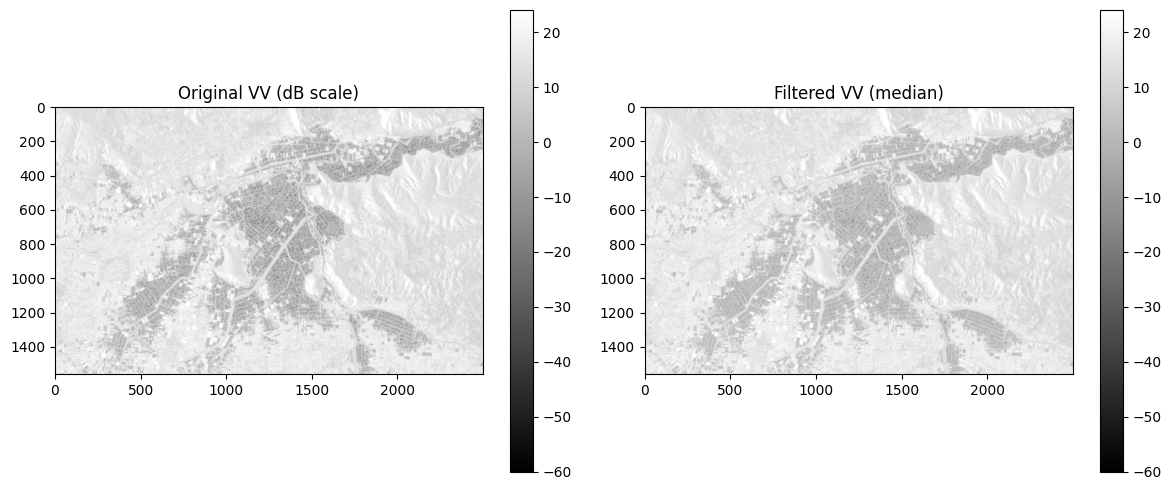

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from skimage.filters import median
from skimage.morphology import disk

# Load the TIFF image

image_path = '/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VV_-_linear_gamma0_–_orthorectified.tiff'  # Replace with actual file path

with rasterio.open(image_path) as src:
    vv_band = src.read(1)
    profile = src.profile

print("Original VV band shape:", vv_band.shape)

#  Convert to decibel scale (from gamma0 linear)
vv_band = np.where(vv_band <= 0, 1e-6, vv_band)
vv_dB = 10 * np.log10(vv_band)

#  Apply speckle noise filtering (median)
filtered_vv_dB = median(vv_dB, disk(1))

# Display original and filtered images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Original VV (dB scale)')
plt.imshow(vv_dB, cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Filtered VV (median)')
plt.imshow(filtered_vv_dB, cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()


Phase 2

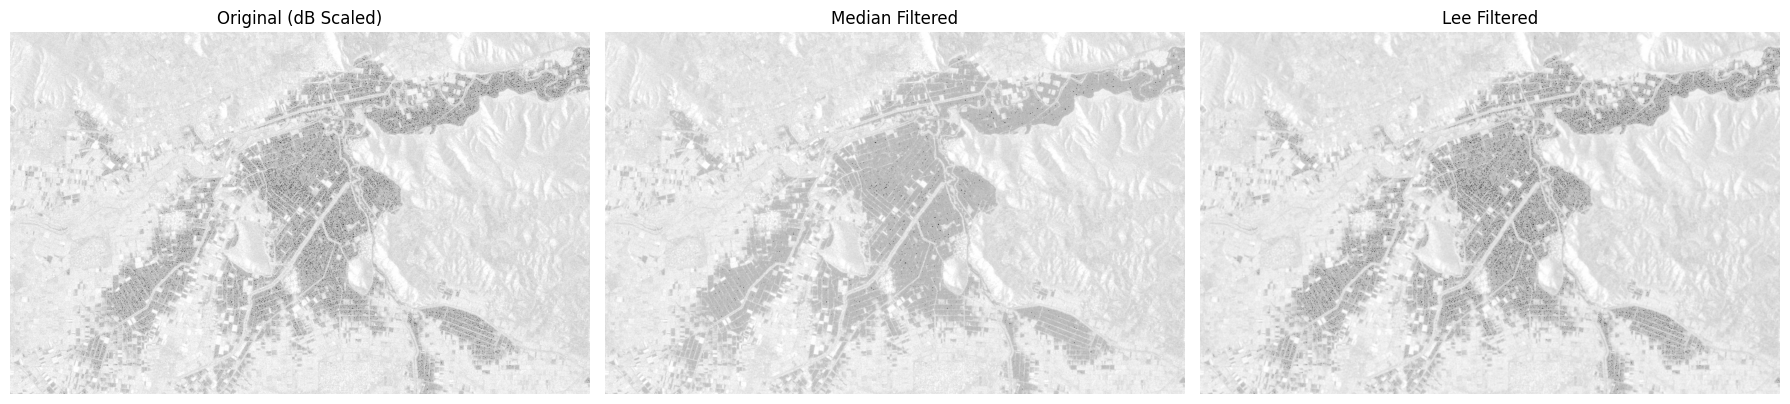

In [ ]:

from scipy.ndimage import median_filter

# Load the image again (or continue from previous phase)
path = '/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VV_-_linear_gamma0_–_orthorectified.tiff'
with rasterio.open(path) as src:
    vv_raw = src.read(1).astype(np.float32)

# ---  Convert to dB scale (avoid log(0) issues) ---
vv_db = 10 * np.log10(vv_raw + 1e-6)  # small epsilon added

# ---  Apply Median Filter ---
vv_median_filtered = median_filter(vv_db, size=3)

# ---  Apply Lee Filter ---
def lee_filter(img, size=5):
    """
    Lee filter for speckle reduction (SAR specific)
    """
    img_mean = cv2.blur(img, (size, size))
    img_sqr_mean = cv2.blur(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = np.var(img)
    img_weights = img_variance / (img_variance + overall_variance)
    lee_filtered = img_mean + img_weights * (img - img_mean)
    return lee_filtered

vv_lee_filtered = lee_filter(vv_db, size=5)





# Normalize for visualization/thresholding
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

vv_norm = normalize(vv_db)
median_norm = normalize(vv_median_filtered)
lee_norm = normalize(vv_lee_filtered)

# --- Show comparison ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(vv_norm, cmap='gray')
axs[0].set_title("Original (dB Scaled)")
axs[1].imshow(median_norm, cmap='gray')
axs[1].set_title("Median Filtered")
axs[2].imshow(lee_norm, cmap='gray')
axs[2].set_title("Lee Filtered")
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()


Phase 3

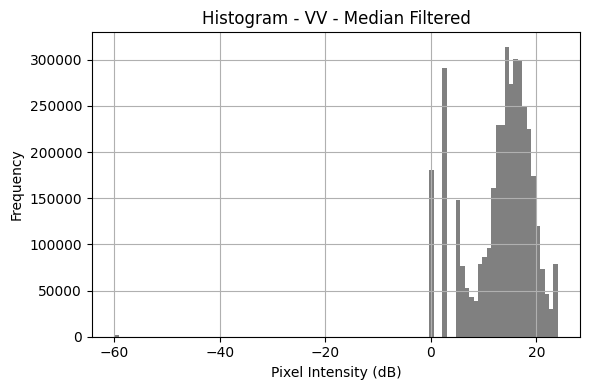

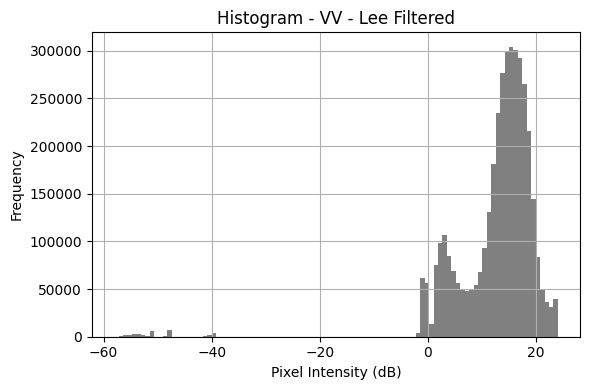

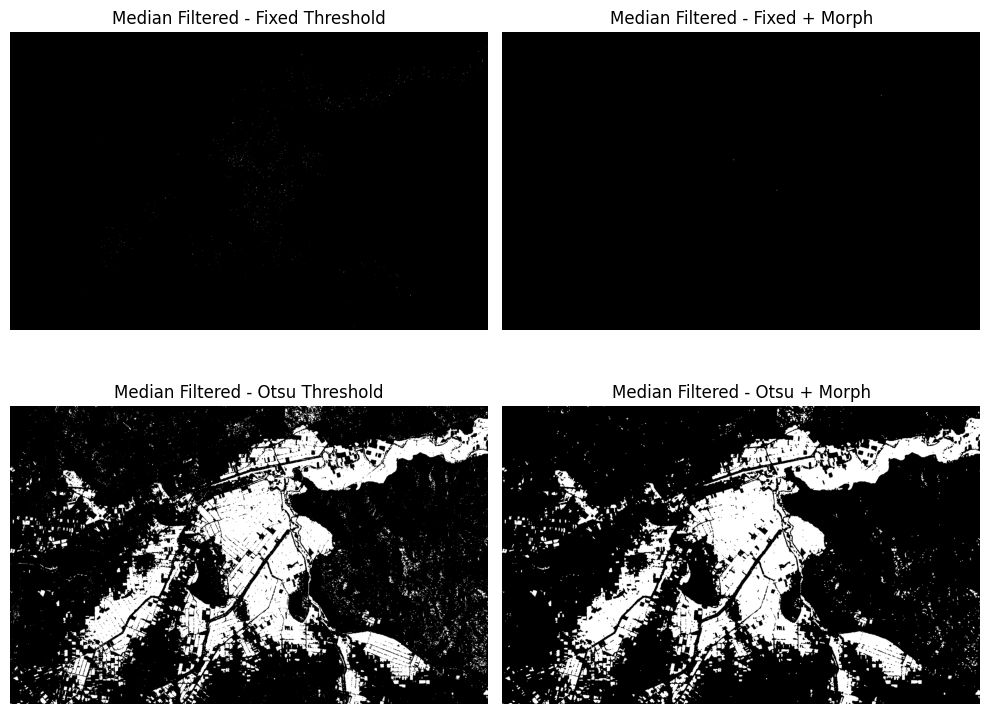

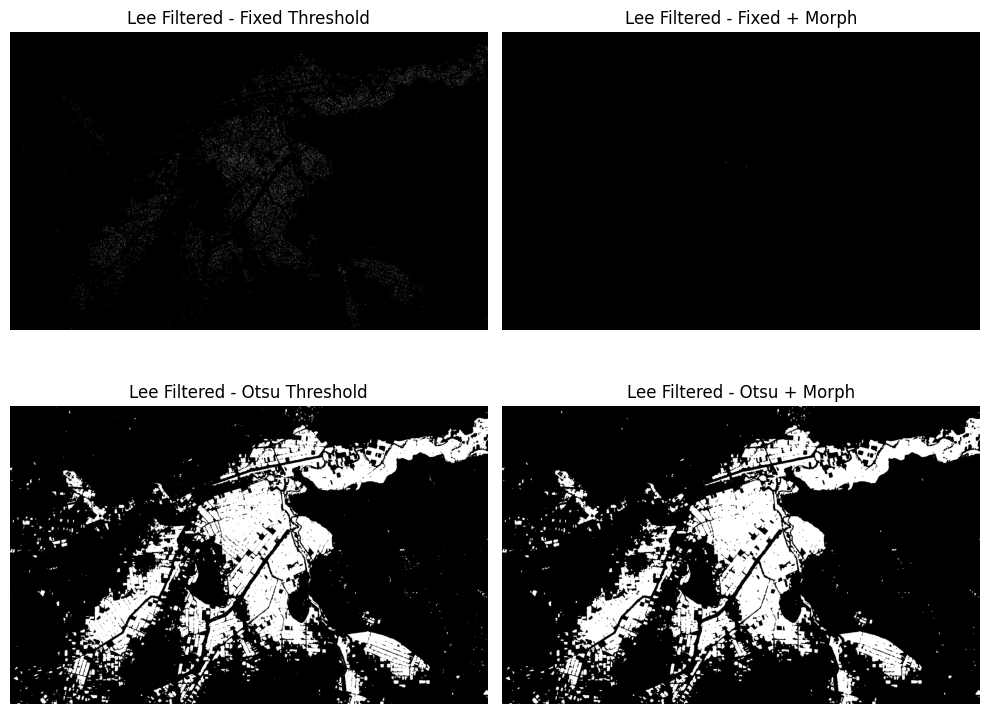

In [ ]:

from skimage.filters import threshold_otsu

# Histogram Visualization
def plot_histogram(img, title):
    plt.figure(figsize=(6, 4))
    plt.hist(img.ravel(), bins=100, color='gray')
    plt.title(f"Histogram - {title}")
    plt.xlabel("Pixel Intensity (dB)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram(vv_median_filtered, "VV - Median Filtered")
plot_histogram(vv_lee_filtered, "VV - Lee Filtered")

# Thresholding Functions
def apply_fixed_threshold(img, threshold_db=-17.0):
    mask = img < threshold_db
    return mask.astype(np.uint8)

def apply_otsu_threshold(img):
    # Normalize to 0–255 for Otsu
    norm_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    thresh_val = threshold_otsu(norm_img)
    mask = norm_img < thresh_val
    return mask.astype(np.uint8)

# Morphological Cleanup
def clean_mask(mask, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed

# Process All Masks
def process_and_compare_masks(filtered_img, title_prefix):
    fixed_mask = apply_fixed_threshold(filtered_img)
    otsu_mask = apply_otsu_threshold(filtered_img)

    fixed_clean = clean_mask(fixed_mask)
    otsu_clean = clean_mask(otsu_mask)

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs[0, 0].imshow(fixed_mask, cmap='gray'); axs[0, 0].set_title(f"{title_prefix} - Fixed Threshold")
    axs[0, 1].imshow(fixed_clean, cmap='gray'); axs[0, 1].set_title(f"{title_prefix} - Fixed + Morph")
    axs[1, 0].imshow(otsu_mask, cmap='gray'); axs[1, 0].set_title(f"{title_prefix} - Otsu Threshold")
    axs[1, 1].imshow(otsu_clean, cmap='gray'); axs[1, 1].set_title(f"{title_prefix} - Otsu + Morph")

    for ax in axs.ravel():
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Apply on both filtered images
process_and_compare_masks(vv_median_filtered, "Median Filtered")
process_and_compare_masks(vv_lee_filtered, "Lee Filtered")


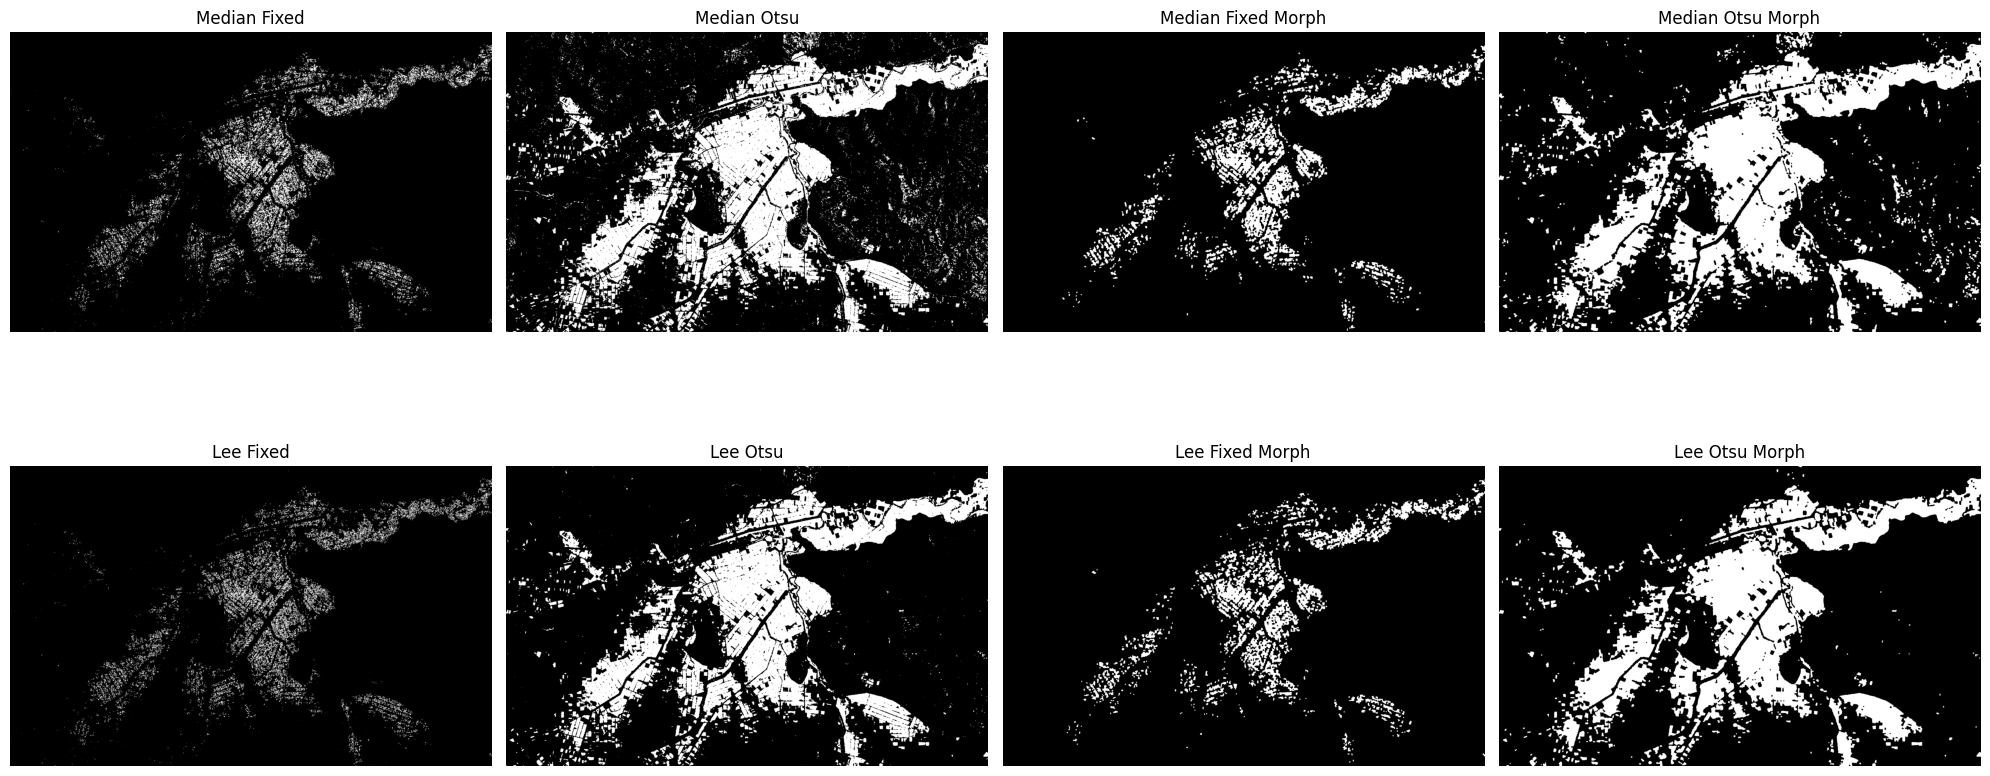

In [ ]:
# phase3 socond iteration



#Functions

def apply_fixed_threshold(image, threshold=0.2):
    return (image < threshold).astype(np.uint8)

def apply_otsu_threshold(image):
    thresh = threshold_otsu(image)
    return (image < thresh).astype(np.uint8)

def apply_morphological_operations(mask, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    return opened

#Apply on both Median and Lee filtered images

masks = {}

# -- Apply on Median Filtered Image --
median_fixed = apply_fixed_threshold(vv_median_filtered)
median_otsu = apply_otsu_threshold(vv_median_filtered)

median_fixed_morph = apply_morphological_operations(median_fixed)
median_otsu_morph = apply_morphological_operations(median_otsu)

# Apply on Lee Filtered Image
lee_fixed = apply_fixed_threshold(vv_lee_filtered)
lee_otsu = apply_otsu_threshold(vv_lee_filtered)

lee_fixed_morph = apply_morphological_operations(lee_fixed)
lee_otsu_morph = apply_morphological_operations(lee_otsu)

# Store final morph masks for next phase
masks["Median_Fixed_Morph"] = median_fixed_morph
masks["Lee_Fixed_Morph"] = lee_fixed_morph

# Visualization
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

axs[0, 0].imshow(median_fixed, cmap='gray'); axs[0, 0].set_title("Median Fixed")
axs[0, 1].imshow(median_otsu, cmap='gray'); axs[0, 1].set_title("Median Otsu")
axs[0, 2].imshow(median_fixed_morph, cmap='gray'); axs[0, 2].set_title("Median Fixed Morph")
axs[0, 3].imshow(median_otsu_morph, cmap='gray'); axs[0, 3].set_title("Median Otsu Morph")

axs[1, 0].imshow(lee_fixed, cmap='gray'); axs[1, 0].set_title("Lee Fixed")
axs[1, 1].imshow(lee_otsu, cmap='gray'); axs[1, 1].set_title("Lee Otsu")
axs[1, 2].imshow(lee_fixed_morph, cmap='gray'); axs[1, 2].set_title("Lee Fixed Morph")
axs[1, 3].imshow(lee_otsu_morph, cmap='gray'); axs[1, 3].set_title("Lee Otsu Morph")

for ax in axs.flatten(): ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
print(masks.keys())


dict_keys(['Median_Fixed_Morph', 'Lee_Fixed_Morph'])


Phase 4

🔵 Median Filtered - Flood Pixels: 0, Flood Area: 0.00%
🟠 Lee Filtered    - Flood Pixels: 0, Flood Area: 0.00%


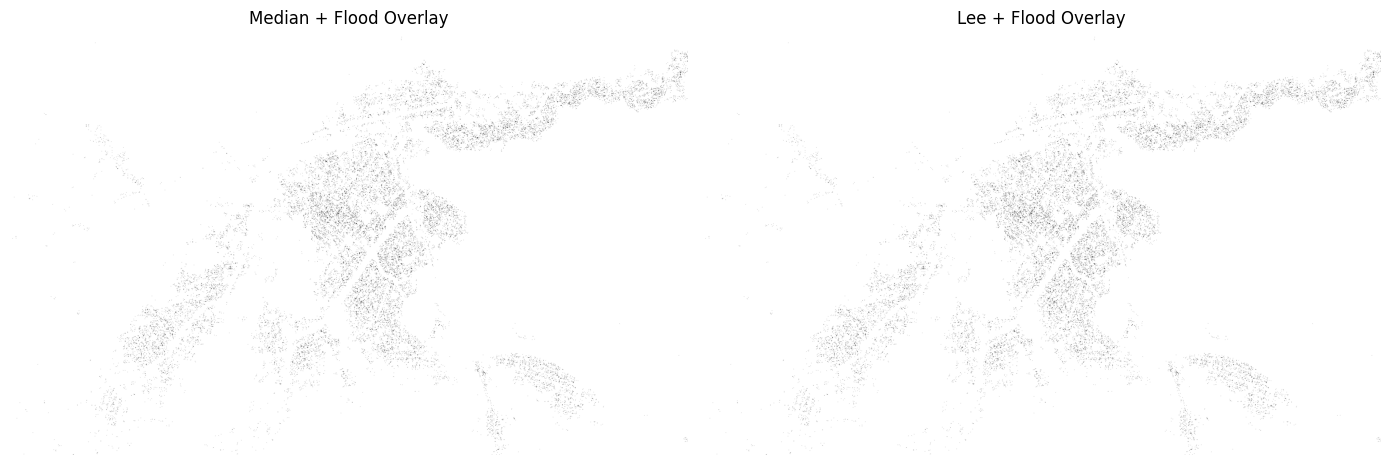

In [ ]:


#Function to calculate flood area in pixels and percentage
def calculate_flood_extent(mask):
    total_pixels = mask.size
    flood_pixels = np.sum(mask == 255)
    percent_flooded = (flood_pixels / total_pixels) * 100
    return flood_pixels, percent_flooded

# Function to overlay mask on original image
def overlay_mask_on_image(original, mask, color=(0, 0, 255), alpha=0.4):
    color_mask = np.zeros_like(original)
    color_mask[mask == 255] = color  # Red for flood
    overlayed = cv2.addWeighted(original, 1, color_mask, alpha, 0)
    return overlayed

# Convert original VV SAR image to 3-channel (for overlay)
vv_3channel = cv2.merge([vv_raw]*3)

# Overlay both flood masks
overlay_median = overlay_mask_on_image(vv_3channel, masks["Median_Fixed_Morph"])
overlay_lee = overlay_mask_on_image(vv_3channel, masks["Lee_Fixed_Morph"])

# Calculate flood area
area_median, perc_median = calculate_flood_extent(masks["Median_Fixed_Morph"])
area_lee, perc_lee = calculate_flood_extent(masks["Lee_Fixed_Morph"])

# Show results
print(f"🔵 Median Filtered - Flood Pixels: {area_median}, Flood Area: {perc_median:.2f}%")
print(f"🟠 Lee Filtered    - Flood Pixels: {area_lee}, Flood Area: {perc_lee:.2f}%")

# Display overlays
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Median + Flood Overlay")
plt.imshow(cv2.cvtColor(overlay_median, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Lee + Flood Overlay")
plt.imshow(cv2.cvtColor(overlay_lee, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.tight_layout()
plt.show()


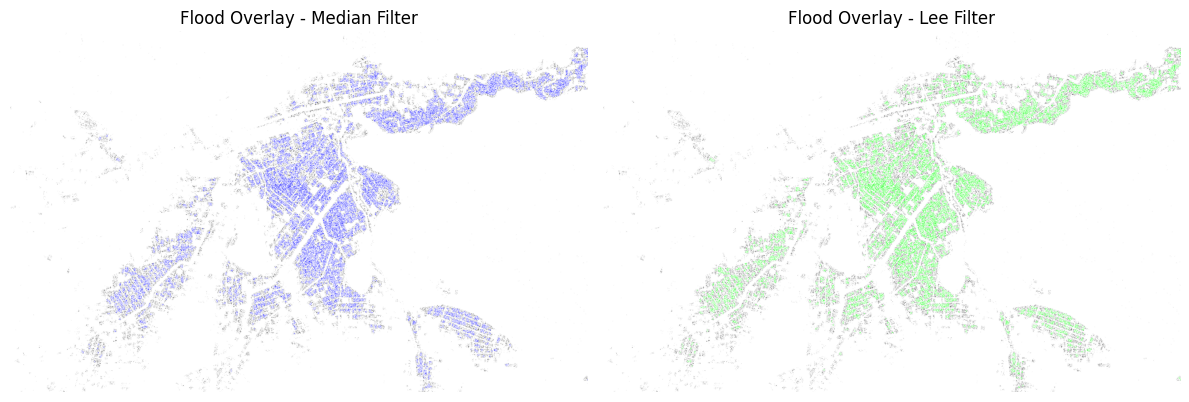

In [ ]:

def create_colored_overlay(base_img, mask, color=(0, 0, 255), alpha=0.4):
    """Overlay mask on base image using transparency"""
    overlay = base_img.copy()
    colored_mask = np.zeros_like(base_img)
    colored_mask[mask == 1] = color  # Apply color to flood areas

    # Blend original with mask using transparency
    cv2.addWeighted(colored_mask, alpha, overlay, 1 - alpha, 0, overlay)
    return overlay

# Convert VV grayscale image to 3-channel for overlay
vv_3channel = cv2.merge([vv_raw]*3)

# Create overlays
overlay_median = create_colored_overlay(vv_3channel, masks["Median_Fixed_Morph"], color=(255, 0, 0))  # blue
overlay_lee = create_colored_overlay(vv_3channel, masks["Lee_Fixed_Morph"], color=(0, 255, 0))       # Green

# Plot the overlays
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Flood Overlay - Median Filter")
plt.imshow(cv2.cvtColor(overlay_median, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Flood Overlay - Lee Filter")
plt.imshow(cv2.cvtColor(overlay_lee, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


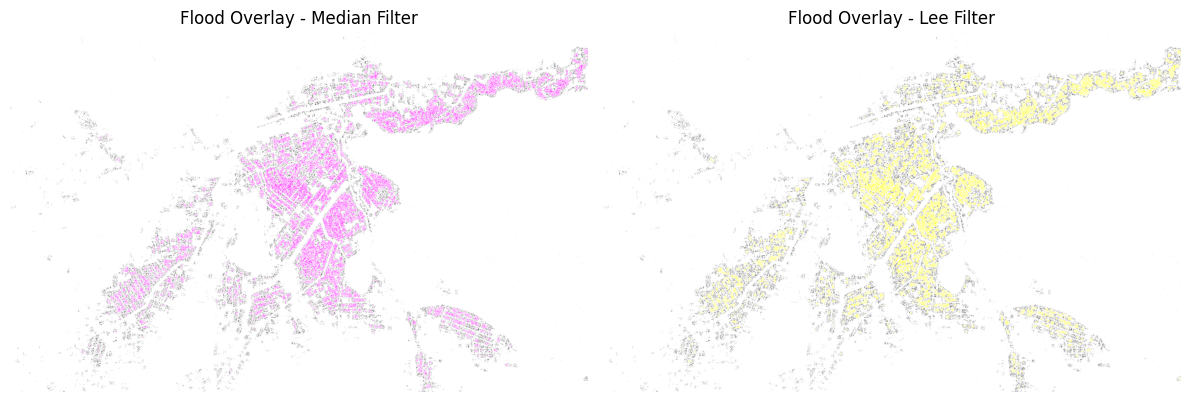

In [ ]:
def create_colored_overlay_with_contours(base_img, mask, color=(0, 255, 255), alpha=0.5, contour_color=(255, 255, 255)):
    """Overlay flood mask with color + draw contours"""
    overlay = base_img.copy()
    colored_mask = np.zeros_like(base_img)
    colored_mask[mask == 1] = color

    # Blend with transparency
    overlay = cv2.addWeighted(colored_mask, alpha, overlay, 1 - alpha, 0)

    # Draw contours for clarity
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, contour_color, thickness=1)

    return overlay

# Overlays with contours
overlay_median = create_colored_overlay_with_contours(vv_3channel, masks["Median_Fixed_Morph"], color=(255, 0, 255))  # Magenta
overlay_lee = create_colored_overlay_with_contours(vv_3channel, masks["Lee_Fixed_Morph"], color=(0, 255, 255))       # yellow

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Flood Overlay - Median Filter")
plt.imshow(cv2.cvtColor(overlay_median, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Flood Overlay - Lee Filter")
plt.imshow(cv2.cvtColor(overlay_lee, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import tifffile as tiff

# Load the multi-band SAR image (VV+VH)

sar_image = tiff.imread("/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VV_(Raw).tiff")
vh_image = tiff.imread("/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VH_(Raw).tiff")

# Store them
vv_raw = sar_image.astype(np.float32)
vh_raw = vh_image.astype(np.float32)


run debugging code at the end first

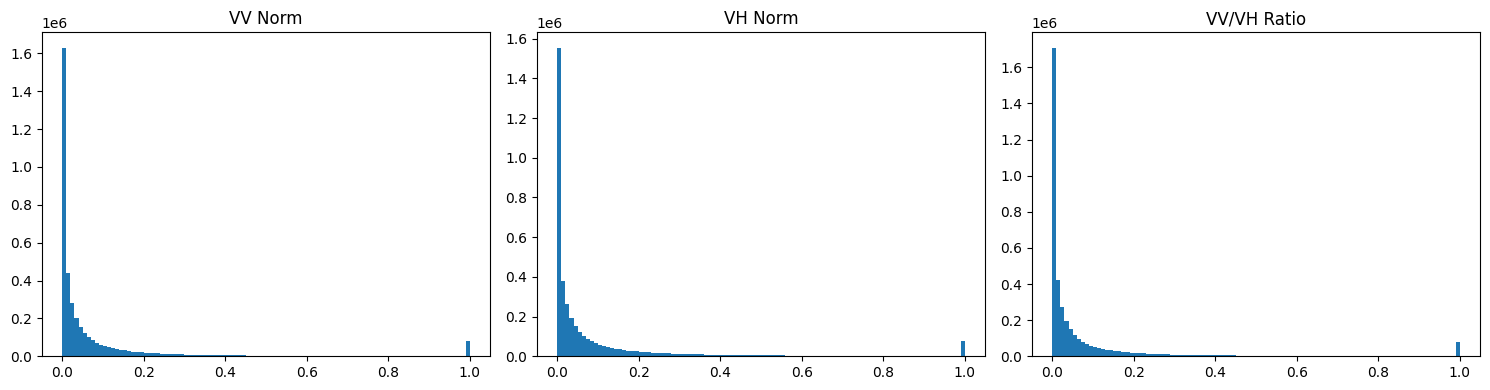

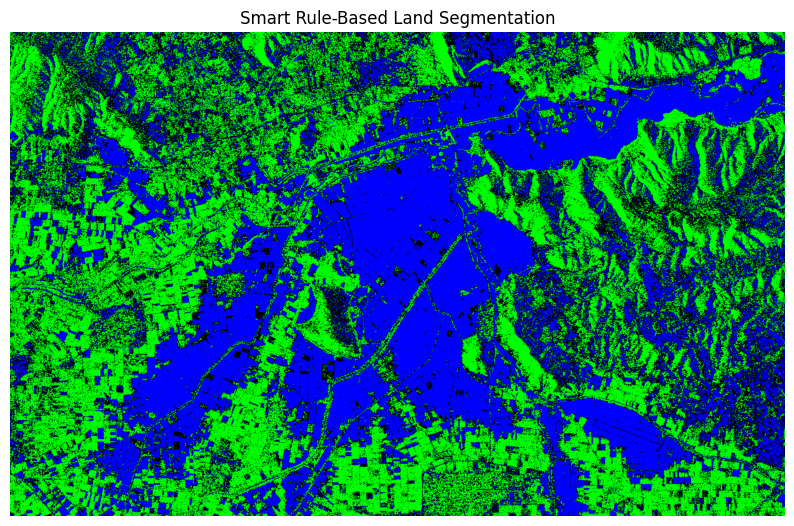

In [ ]:


# Normalize function
def normalize(img):
    img_min, img_max = np.percentile(img, (2, 98))  # robust normalization
    return np.clip((img - img_min) / (img_max - img_min + 1e-6), 0, 1)

# Normalize VV, VH, and Ratio
vv_norm = normalize(vv_raw)
vh_norm = normalize(vh_raw)
ratio = normalize(vv_raw / (vh_raw + 1e-6))

# Plot histograms to see value spread (helpful for tuning)
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1); plt.hist(vv_norm.ravel(), bins=100); plt.title("VV Norm")
plt.subplot(1, 3, 2); plt.hist(vh_norm.ravel(), bins=100); plt.title("VH Norm")
plt.subplot(1, 3, 3); plt.hist(ratio.ravel(), bins=100); plt.title("VV/VH Ratio")
plt.tight_layout(); plt.show()

# Dynamic Thresholds via Percentiles
vv_thresh = np.percentile(vv_norm, 35)
vh_thresh = np.percentile(vh_norm, 60)
ratio_thresh = np.percentile(ratio, 40)

# Rule-Based Classification
water = (vv_norm < vv_thresh) & (ratio < ratio_thresh)
vegetation = (vh_norm > vh_thresh)
urban = (vv_norm > vv_thresh) & (vh_norm > vh_thresh)

# Priority Encoding
# Priority: Water > Vegetation > Urban > Background
class_map = np.zeros_like(vv_norm, dtype=np.uint8)
class_map[urban] = 3
class_map[vegetation] = 2
class_map[water] = 1

# Color Mapping
color_map = {
    0: [0, 0, 0],         # Background - Black
    1: [0, 0, 255],       # Water - Blue
    2: [0, 255, 0],       # Vegetation - Green
    3: [200, 200, 200]    # Urban - Light Gray
}

segmented_image = np.zeros((vv_norm.shape[0], vv_norm.shape[1], 3), dtype=np.uint8)

for cls_id, color in color_map.items():
    mask = (class_map == cls_id)
    segmented_image[mask] = np.array(color, dtype=np.uint8)



# Show segmented output
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image)
plt.title("Smart Rule-Based Land Segmentation")
plt.axis('off')
plt.show()


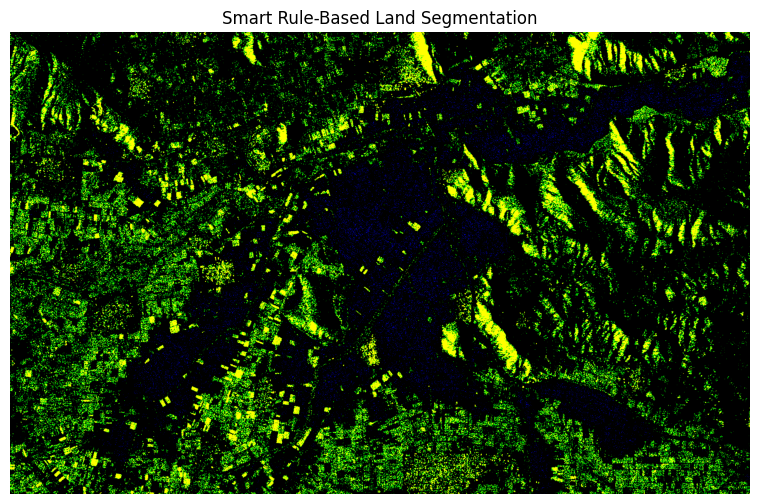

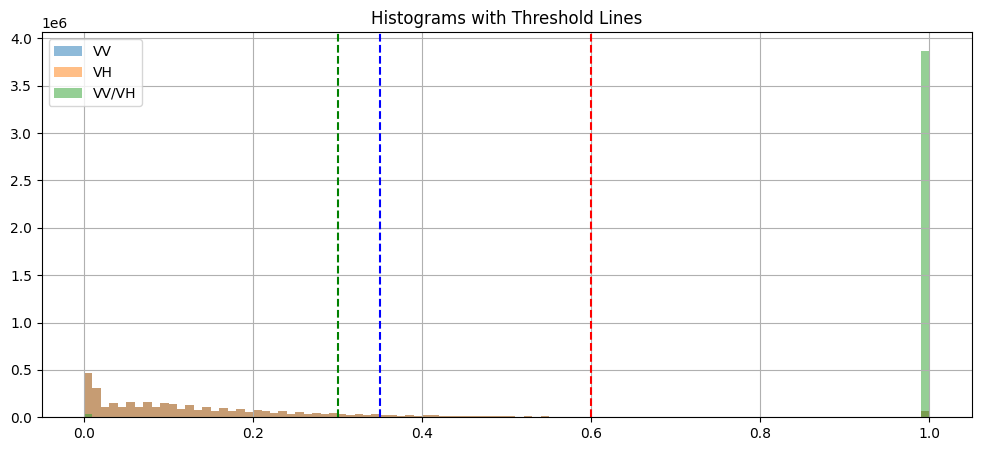

In [ ]:


# ---  Load SAR image ---
sar_image = cv2.imread('/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VV_-_linear_gamma0_–_orthorectified.tiff', cv2.IMREAD_UNCHANGED)
sar_image = cv2.cvtColor(sar_image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed

# ---  Split VV and VH ---
vv = sar_image[:, :, 0].astype(np.float32)
vh = sar_image[:, :, 1].astype(np.float32)

# --- Normalize channels ---
vv_norm = cv2.normalize(vv, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
vh_norm = cv2.normalize(vh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# --- Ratio ---
ratio = np.divide(vv_norm, vh_norm + 1e-6)

# ---  Rule-based segmentation with TUNED thresholds ---
vv_thresh = 0.35
vh_thresh = 0.3
ratio_thresh = 0.6

# Rules: water (low VV & ratio), vegetation (high VH), urban (high VV & VH)
water = (vv_norm < vv_thresh) & (ratio < ratio_thresh)
vegetation = (vh_norm > vh_thresh)
urban = (vv_norm > 0.5) & (vh_norm > 0.4)

# ---  Create class map ---
class_map = np.zeros_like(vv, dtype=np.uint8)
class_map[water] = 1
class_map[vegetation] = 2
class_map[urban] = 3

# ---  Color map ---
color_map = {
    0: [0, 0, 0],          # Background - black
    1: [0, 0, 255],        # Water - red
    2: [0, 255, 0],        # Vegetation - green
    3: [255, 255, 0],      # Urban - yellow
}

segmented_image = np.zeros((*class_map.shape, 3), dtype=np.uint8)
for cls_id, color in color_map.items():
    segmented_image[class_map == cls_id] = color

# ---  Show segmented output ---
plt.figure(figsize=(10, 6))
plt.imshow(segmented_image)
plt.title("Smart Rule-Based Land Segmentation")
plt.axis('off')
plt.show()

# ---  Histogram debugging (optional) ---
plt.figure(figsize=(12, 5))
plt.hist(vv_norm.ravel(), bins=100, alpha=0.5, label='VV')
plt.axvline(vv_thresh, color='blue', linestyle='--')
plt.hist(vh_norm.ravel(), bins=100, alpha=0.5, label='VH')
plt.axvline(vh_thresh, color='green', linestyle='--')
plt.hist(ratio.ravel(), bins=100, alpha=0.5, label='VV/VH')
plt.axvline(ratio_thresh, color='red', linestyle='--')
plt.legend(); plt.title("Histograms with Threshold Lines")
plt.grid(True)
plt.show()


# ***End of Code***

  .

.

.

.

.

.

.

.

Debugging code below

Initial loaded vv_raw shape: (1561, 2500, 2), dtype: float32
Initial loaded vh_raw shape: (1561, 2500, 2), dtype: float32
Data shape (1561, 2500, 2) suggests complex I/Q. Calculating amplitude.
 -> Resulting amplitude shape: (1561, 2500)
Data shape (1561, 2500, 2) suggests complex I/Q. Calculating amplitude.
 -> Resulting amplitude shape: (1561, 2500)
Using vv_raw (amplitude) shape: (1561, 2500)
Using vh_raw (amplitude) shape: (1561, 2500)
Normalized vv_norm shape: (1561, 2500)
Normalized vh_norm shape: (1561, 2500)
Normalized ratio shape: (1561, 2500)
--- Analyzing Normalized Amplitude Distributions ---


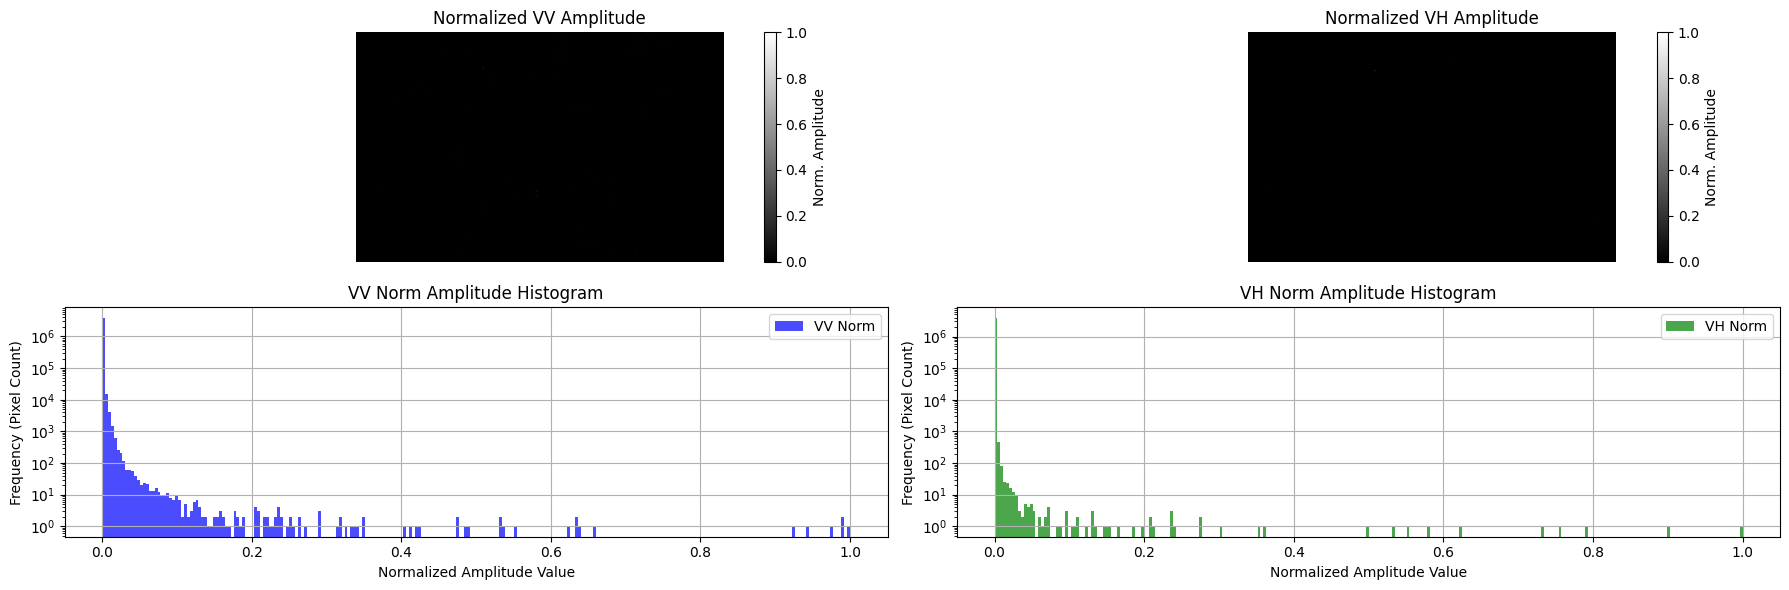

--- End Analysis ---
Initial class_map shape: (1561, 2500)
Attempting with thresholds -> Water VV < 0.02, Veg VH > 0.04, Urban VV > 0.06 & VH > 0.05
Class map unique values after assignment: [0 1 2 3]
Created segmented_image with shape: (1561, 2500, 3)


In [ ]:

import tifffile as tiff

# --- Load your vv_raw and vh_raw data here ---
# Example paths (replace with your actual paths)
vv_raw_path = "/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VV_(Raw).tiff"
vh_raw_path = "/content/drive/MyDrive/Files/2023-09-12-00_00_2023-09-12-23_59_Sentinel-1_IW_VV+VH_VH_(Raw).tiff"

vv_raw_loaded = tiff.imread(vv_raw_path)
vh_raw_loaded = tiff.imread(vh_raw_path)

print(f"Initial loaded vv_raw shape: {vv_raw_loaded.shape}, dtype: {vv_raw_loaded.dtype}")
print(f"Initial loaded vh_raw shape: {vh_raw_loaded.shape}, dtype: {vh_raw_loaded.dtype}")

# --- Process potential Complex Data (I/Q) to Amplitude ---

def get_amplitude_from_complex(data):
    """Calculates amplitude from complex (I/Q) data if shape is (h, w, 2)."""
    if data.ndim == 3 and data.shape[-1] == 2:
        print(f"Data shape {data.shape} suggests complex I/Q. Calculating amplitude.")
        # Ensure calculations are done in float64 for precision, especially for squaring
        I = data[..., 0].astype(np.float64)
        Q = data[..., 1].astype(np.float64)
        amplitude = np.sqrt(I**2 + Q**2)
        print(f" -> Resulting amplitude shape: {amplitude.shape}")
        # Return as float32, which is standard for image processing
        return amplitude.astype(np.float32)
    elif data.ndim == 2:
        print(f"Data shape {data.shape} is already 2D. Assuming it's amplitude/intensity.")
        # Ensure it's float32 for consistency
        return data.astype(np.float32)
    else:
        raise ValueError(f"Unexpected data shape: {data.shape}. Expected 2D or (h, w, 2).")

vv_raw = get_amplitude_from_complex(vv_raw_loaded)
vh_raw = get_amplitude_from_complex(vh_raw_loaded)

# --- Now vv_raw and vh_raw should be 2D amplitude arrays ---

# Check for shape mismatch between vv and vh AFTER processing
if vv_raw.shape != vh_raw.shape:
    raise ValueError(f"Shapes of processed vv_raw {vv_raw.shape} and vh_raw {vh_raw.shape} do not match.")

print(f"Using vv_raw (amplitude) shape: {vv_raw.shape}")
print(f"Using vh_raw (amplitude) shape: {vh_raw.shape}")

# --- Normalize image to [0, 1] ---
def normalize(img):
    """ Normalizes numpy array to the range [0, 1]. Handles flat images. """
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val < 1e-8: # Avoid division by zero if the image has no variation
        print("Warning: Image appears flat (all values are nearly the same). Normalizing to 0.")
        return np.zeros_like(img, dtype=np.float32)
    # Perform normalization in float64 for precision then convert back
    img_norm = ((img.astype(np.float64) - min_val) / (max_val - min_val))
    return img_norm.astype(np.float32)

# --- Step 1: Normalize all bands ---
vv_norm = normalize(vv_raw) # vv_raw is now amplitude
vh_norm = normalize(vh_raw) # vh_raw is now amplitude

# Add a small epsilon to prevent division by zero in the ratio calculation
epsilon = 1e-8 # Use a slightly smaller epsilon for normalized data
vh_norm_safe = np.maximum(vh_norm, epsilon)
ratio = normalize(vv_norm / vh_norm_safe) # Normalize the calculated ratio

print(f"Normalized vv_norm shape: {vv_norm.shape}")
print(f"Normalized vh_norm shape: {vh_norm.shape}")
print(f"Normalized ratio shape: {ratio.shape}")




# --- Add this section for Debugging ---

print("--- Analyzing Normalized Amplitude Distributions ---")

plt.figure(figsize=(18, 6)) # Increased figure size

# Plot vv_norm grayscale image
plt.subplot(2, 2, 1)
plt.imshow(vv_norm, cmap='gray', vmin=0, vmax=1) # Explicitly set range for consistency
plt.title('Normalized VV Amplitude')
plt.colorbar(label='Norm. Amplitude')
plt.axis('off')

# Plot vh_norm grayscale image
plt.subplot(2, 2, 2)
plt.imshow(vh_norm, cmap='gray', vmin=0, vmax=1) # Explicitly set range for consistency
plt.title('Normalized VH Amplitude')
plt.colorbar(label='Norm. Amplitude')
plt.axis('off')

# Plot vv_norm histogram
plt.subplot(2, 2, 3)
plt.hist(vv_norm.ravel(), bins=256, range=(0, 1), color='blue', alpha=0.7, label='VV Norm')
plt.title('VV Norm Amplitude Histogram')
plt.xlabel('Normalized Amplitude Value')
plt.ylabel('Frequency (Pixel Count)')
plt.grid(True)
plt.yscale('log') # Use log scale for y-axis to see smaller peaks better
plt.legend()

# Plot vh_norm histogram
plt.subplot(2, 2, 4)
plt.hist(vh_norm.ravel(), bins=256, range=(0, 1), color='green', alpha=0.7, label='VH Norm')
plt.title('VH Norm Amplitude Histogram')
plt.xlabel('Normalized Amplitude Value')
plt.ylabel('Frequency (Pixel Count)')
plt.grid(True)
plt.yscale('log') # Use log scale for y-axis
plt.legend()

plt.tight_layout()
plt.show()

print("--- End Analysis ---")
# --- End Debugging Section ---



height, width = vv_norm.shape
class_map = np.zeros((height, width), dtype=np.uint8)
print(f"Initial class_map shape: {class_map.shape}")

# Define thresholds based on NORMALIZED AMPLITUDE [0, 1] - MODIFY THESE CAREFULLY!
# *** These are illustrative guesses based on the histogram shape - adjust them ***
water_threshold_vv = 0.02   # e.g., Threshold for the main peak near zero
veg_threshold_vh = 0.04     # e.g., VH slightly above the main background peak
urban_threshold_vv = 0.06   # e.g., VV noticeably higher than background
urban_threshold_vh = 0.05   # e.g., VH noticeably higher than background

print(f"Attempting with thresholds -> Water VV < {water_threshold_vv}, Veg VH > {veg_threshold_vh}, Urban VV > {urban_threshold_vv} & VH > {urban_threshold_vh}")

# Apply masks - Let's try assigning brighter/rarer classes first
# Urban: pixels that are relatively bright in both VV and VH (based on low thresholds)
urban_mask = (vv_norm > urban_threshold_vv) & (vh_norm > urban_threshold_vh)

# Vegetation: pixels with VH above a certain low threshold, but *not* classified as urban
# (This assumes vegetation has higher VH than the main background, but maybe lower VV/VH than urban)
vegetation_mask = (vh_norm > veg_threshold_vh) & (~urban_mask)

# Water/Background: pixels with very low VV, and not classified as urban or vegetation
water_mask = (vv_norm < water_threshold_vv) & (~urban_mask) & (~vegetation_mask)

# Assign class labels - Order: Urban -> Vegetation -> Water
class_map[urban_mask] = 3
class_map[vegetation_mask] = 2
class_map[water_mask] = 1 # Assign water/background last

print(f"Class map unique values after assignment: {np.unique(class_map)}")

# ---  Define Color Map (BGR for OpenCV compatibility) ---
color_map = {
    0: [0, 0, 0],       # 0: Black (unclassified)
    1: [255, 0, 0],     # 1: Blue (Water/Background)
    2: [0, 255, 0],     # 2: Green (Vegetation?)
    3: [0, 0, 255],     # 3: Red (Urban?)
}

# --- Step 4: Create Color Image ---
segmented_image = np.zeros((height, width, 3), dtype=np.uint8)
print(f"Created segmented_image with shape: {segmented_image.shape}")

for cls_id, color_bgr in color_map.items():
    mask = (class_map == cls_id)
    segmented_image[mask] = np.array(color_bgr, dtype=np.uint8)

# --- Show result using Matplotlib --

# ---  Define Color Map (BGR for OpenCV compatibility) ---
color_map = {
    0: [0, 0, 0],       # 0: Black (background/unclassified)
    1: [255, 0, 0],     # 1: Blue (water)
    2: [0, 255, 0],     # 2: Green (vegetation)
    3: [0, 0, 255],     # 3: Red (urban)
}

# # ---  Create Color Image ---
# segmented_image = np.zeros((height, width, 3), dtype=np.uint8)
# print(f"Created segmented_image with shape: {segmented_image.shape}")

for cls_id, color_bgr in color_map.items():
    mask = (class_map == cls_id)
    segmented_image[mask] = np.array(color_bgr, dtype=np.uint8)

